# Test suite for env_template_sa

In [1]:
from marketsai.economies.template_single_agent.env_template_sa import TemplateSA
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time

In [2]:
# environment config
env_config = {
    "horizon": 200,
    "eval_mode": False,
    "analysis_mode": False,
    "simul_mode": False,
    "max_action": 0.5,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "alpha": 0.5,
        "delta": 0.04,
        "beta": 0.99,
    },
}

In [3]:
# validate spaces
env = TemplateSA(env_config=env_config)
print(
    "action space type:",
    type(env.action_space.sample()),
    "action space sample:",
    env.action_space.sample(),
)
print(
    "obs space type:",
    type(env.observation_space.sample()),
    "obs space sample:",
    env.observation_space.sample(),
)
obs_init = env.reset()
print(
    "obs_init contained in obs_space?",
    env.observation_space.contains(obs_init),
)
if not env.observation_space.contains(obs_init):
    print(obs_init)
print(
    "random number in [-1,1] contained in action_space?",
    env.action_space.contains(np.array([np.random.uniform(-1, 1)])),
)
obs, rew, done, info = env.step(env.action_space.sample())
print(
    "obs after step contained in obs space?",
    env.observation_space.contains(obs),
        )

action space type: <class 'numpy.ndarray'> action space sample: [-0.16331571]
obs space type: <class 'tuple'> obs space sample: (array([0.19790517], dtype=float32), array([0]))
obs_init contained in obs_space? True
random number in [-1,1] contained in action_space? True
obs after step contained in obs space? True


In [4]:
# simulate
SIMUL_PERIODS = 10000
env = TemplateSA(env_config=env_config)
cap_stats, rew_stats = env.random_sample(SIMUL_PERIODS)
print(cap_stats, rew_stats)

[56.98698953432635, 1.0146242061445143, 29.064102702894882, 10.484629811316463] [2.0836495591715605, -0.44138249046184563, 1.3269847507465646, 0.34035519599881664]


cap_stats: [41.329682948573506, 2.9939516129032215, 28.041765479785745, 9.519782350305316] reward_stats: [1.8603065451428222, -0.0315189330975058, 1.3012836831902057, 0.360860529854743]


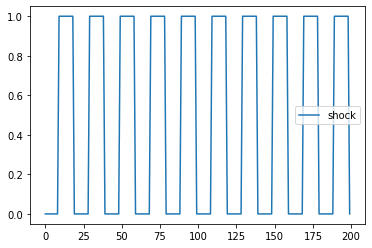

In [5]:
# run analysis mode
env_config_analysis = env_config.copy()
env_config_analysis["analysis_mode"] = True
env = TemplateSA(env_config=env_config_analysis)
k_list = []
rew_list = []
shock_list = []

env.reset()
for t in range(200):
    if t % 200 == 0:
        obs = env.reset()
    obs, rew, done, info = env.step(env.action_space.sample())
    shock_list.append(env.obs_global[1])
    k_list.append(info["capital"])
    rew_list.append(info["rewards"])
print(
    "cap_stats:",
    [
        np.max(k_list),
        np.min(k_list),
        np.mean(k_list),
        np.std(k_list),
    ],
    "reward_stats:",
    [np.max(rew_list), np.min(rew_list), np.mean(rew_list), np.std(rew_list)],
)
plt.plot(shock_list)
plt.legend(["shock"])
plt.show()

cap_stats: [34.968797597255175, 2.9939516129032215, 25.751946487234655, 8.970144937338883] reward_stats: [1.84041458962376, 0.03673539019008663, 1.2713367120661774, 0.3704952790031564]


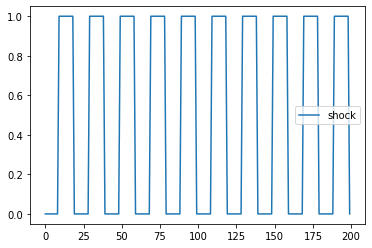

In [6]:
# run evaluation mode
env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
env_config_eval["simul_mode"] = True
env = TemplateSA(env_config=env_config_eval)
k_list = []
rew_list = []
shock_list = []

env.reset()
for t in range(200):
    if t % 200 == 0:
        obs = env.reset()
    obs, rew, done, info = env.step(env.action_space.sample())
    # print(obs, "\n", rew, "\n", done, "\n", info)

    k_list.append(info["capital"])
    shock_list.append(env.obs_global[1])
    rew_list.append(info["rewards"])
print(
    "cap_stats:",
    [
        np.max(k_list),
        np.min(k_list),
        np.mean(k_list),
        np.std(k_list),
    ],
    "reward_stats:",
    [np.max(rew_list), np.min(rew_list), np.mean(rew_list), np.std(rew_list)],
)

plt.plot(shock_list)
plt.legend(["shock"])
plt.show()
